In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

#from google.colab import files
#uploaded = files.upload()

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

plt.rcParams.update({'font.size': 20})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def test_stationarity(df, ts):
  """
  Test stationarity using moving average statistics and Dickey-Fuller test
  Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
  """

  # Determing rolling statistics
  rolmean = df[ts].rolling(window = 12, center = False).mean()
  rolstd = df[ts].rolling(window = 12, center = False).std()

  # Plot rolling statistics:
  plt.figure(figsize=(16,12))
  orig = plt.plot(df[ts],
  color = '#1B4C6B',
  label = 'Original')
  mean = plt.plot(rolmean,
  color = '#B87333',
  label = 'Rolling Mean')
  std = plt.plot(rolstd,
  color = 'black',
  label = 'Rolling Std')
  plt.legend(loc = 'best')
  plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
  plt.xticks(rotation = 45)
  plt.show(block = False)
  plt.close()

  # Perform Dickey-Fuller test:
  # Null Hypothesis (H_0): time series is not stationary
  # Alternate Hypothesis (H_1): time series is stationary
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(df[ts],
  autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],
  index = ['Test Statistic',
  'p-value',
  '# Lags Used',
  'Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)


def log_trans(df,ts):return df[ts].apply(lambda x:np.log(x))

def plot_decomposition(df, ts,trend,seasonal, residual):

  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (20, 8), sharex = True)

  ax1.plot(df[ts], label = 'Original', c = '#1B4C6B')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend', c = '#1B4C6B')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality', c = '#1B4C6B')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals', c = '#1B4C6B')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  #plt.subtitle('Signal Decomposition of  %s' %(ts), x =0.5, y= 1.05, fontsize = 18)
  plt.show()

def run_arima(df,ts,p,d,q):

  model = ARIMA(df[ts],order = (p,d,q))
  results_arima = model.fit(disp=-1)

  len_results = len(results_arima.fittedvalues)
  ts_modified = df[ts][-len_results:]

  rss = sum((results_arima.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss/len(df[ts]))

  print('the root mean squared error is',rmse)

  plt.figure(figsize=(16,12))
  plt.plot(df[ts], c = '#1B4C6B', alpha =.75)
  plt.plot(results_arima.fittedvalues, c='#B87333' , alpha =.75)
  title = ts + ' plot'
  plt.title(title)
  plt.xlabel("Date")
  plt.show()

  return results_arima

In [ ]:
#read in and format training data
df = pd.read_csv('Walmart_train.csv')
df = df.loc[(df['Dept'] == 13)]
train = pd.DataFrame()
train['ts'] = df.groupby('Date')['Weekly_Sales'].agg('sum')
train.index = pd.to_datetime(train.index, format="%Y-%m-%d")

df = pd.read_csv('Walmart_test.csv')
df = df.loc[(df['Dept'] == 13)]
test = pd.DataFrame()
test['ts'] = df.groupby('Date')['IsHoliday'].agg('sum')
test.index = pd.to_datetime(test.index, format="%Y-%m-%d")


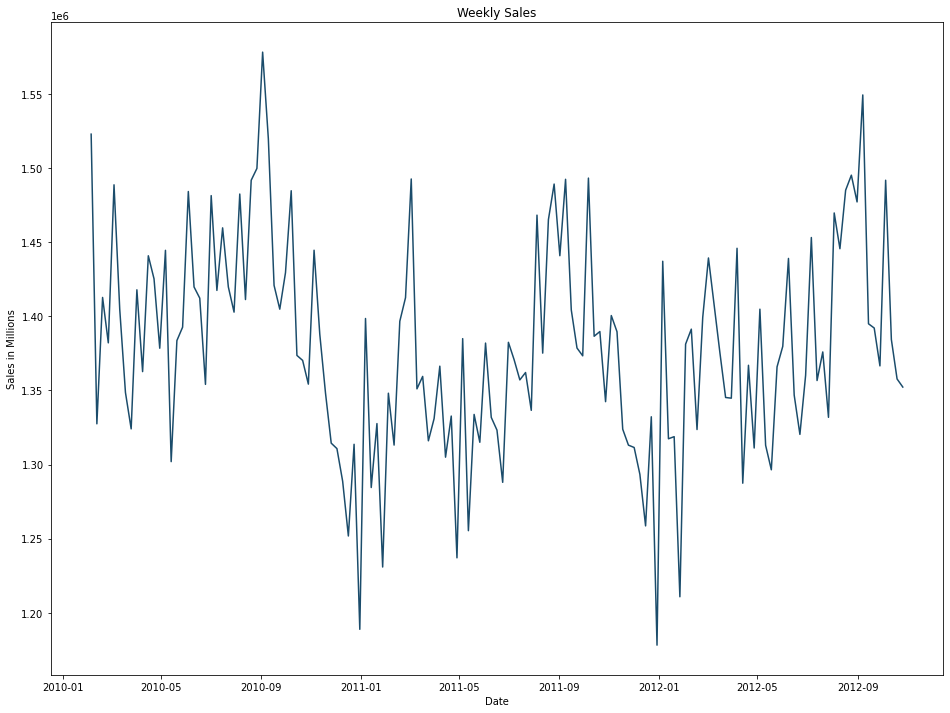

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(train.ts, c = '#1B4C6B')
plt.title("Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Sales in Millions")
plt.show()

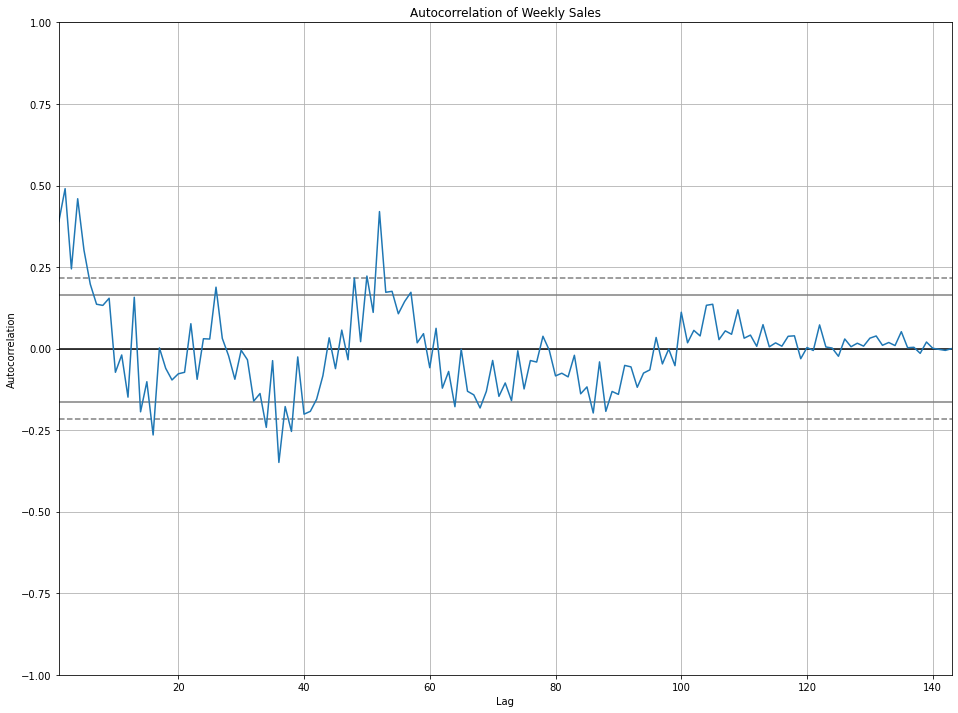

In [ ]:
plt.figure(figsize=(16,12))
pd.plotting.autocorrelation_plot(train).plot(colors ='#1B4C6B') 
plt.title("Autocorrelation of Weekly Sales")
plt.show()

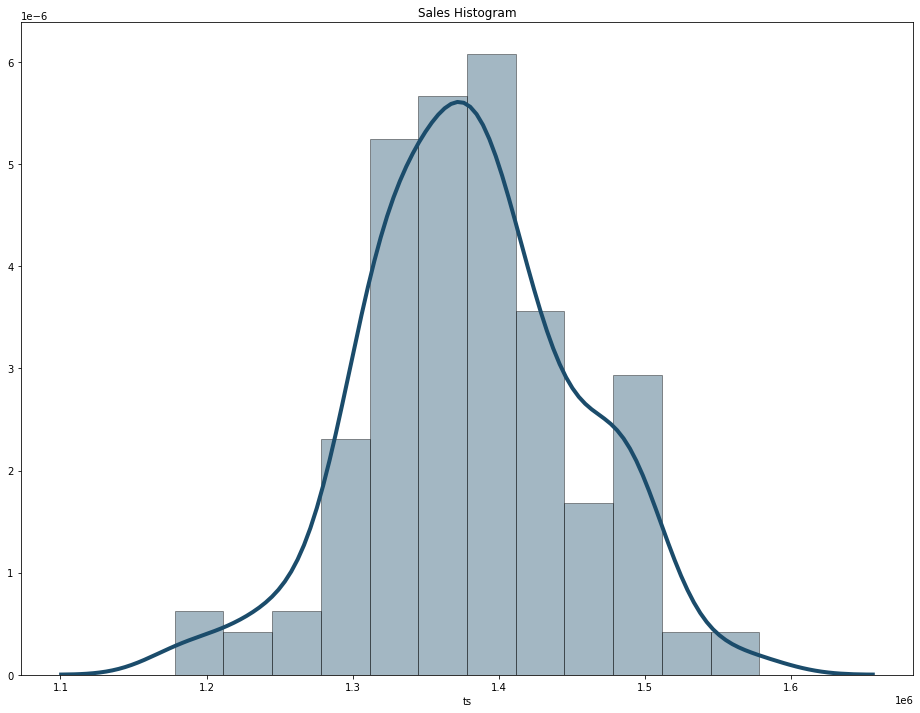

In [ ]:
plt.figure(figsize=(16,12))
sns.distplot(train['ts'], hist=True, kde=True,color = '#1B4C6B', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
plt.title("Sales Histogram")
plt.show()

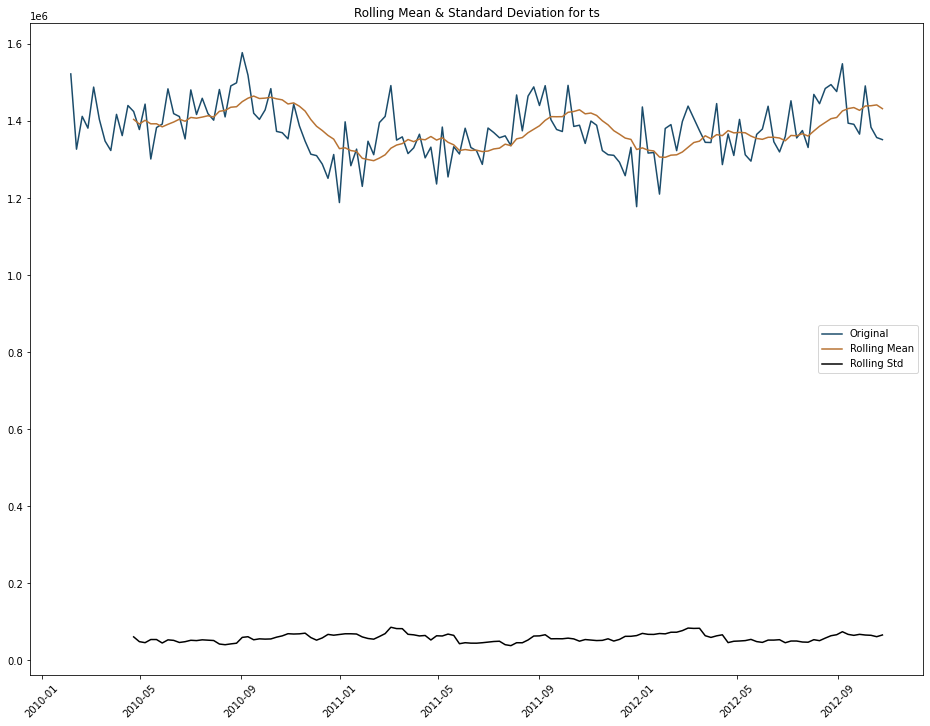

Results of Dickey-Fuller Test:
Test Statistic                  -3.099275
p-value                          0.026607
# Lags Used                     14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
test_stationarity(train,"ts")

In [ ]:
train['ts_log'] = log_trans(train, 'ts')

In [ ]:
decomp  = seasonal_decompose(train['ts_log'],freq=52, extrapolate_trend =2)

In [ ]:
ndf = train
ndf.loc[:,'trend'] = decomp.trend
ndf.loc[:,'seasonal'] = decomp.seasonal
ndf.loc[:,'resid'] = decomp.resid

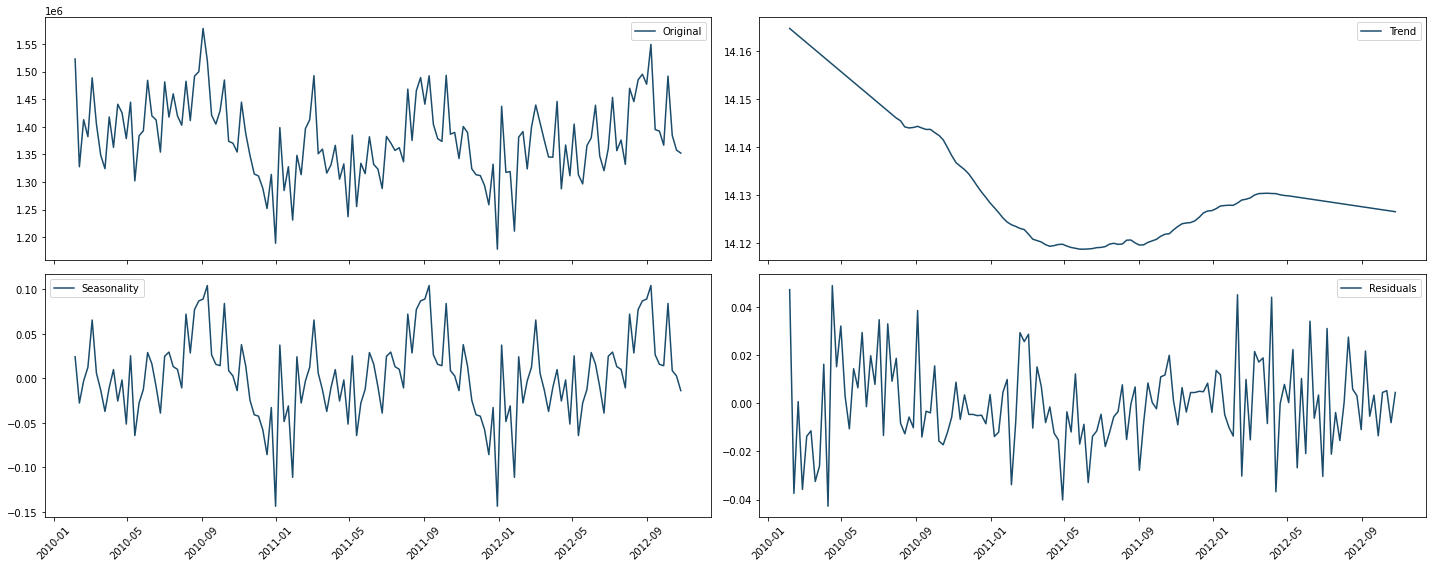

In [ ]:
plot_decomposition(ndf, ts = 'ts', trend= 'trend',seasonal = 'seasonal' , residual = 'resid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


the root mean squared error is 0.01610891129066714


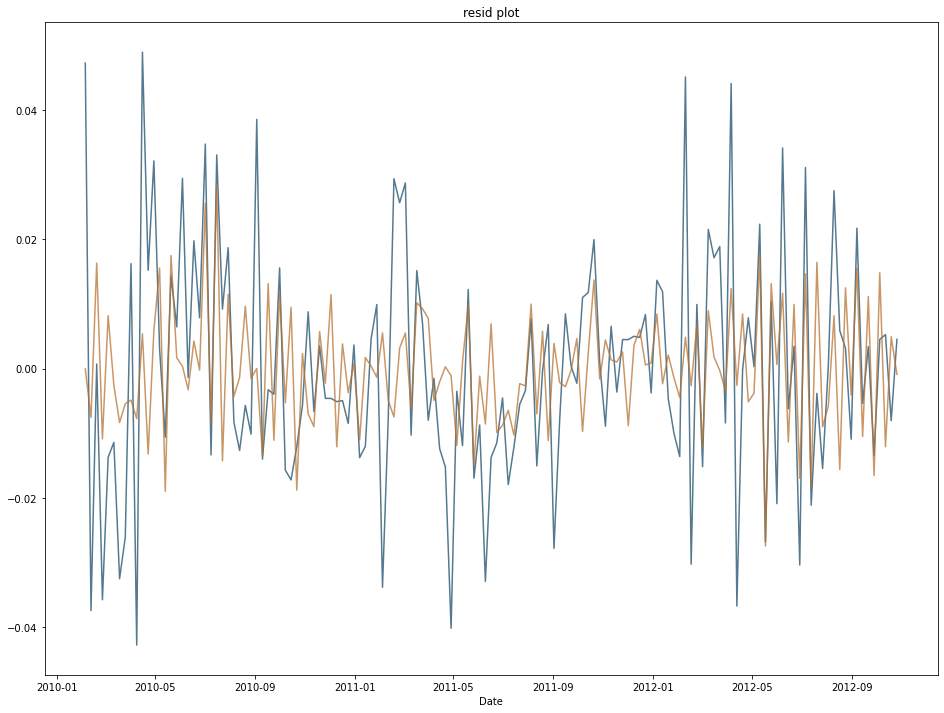

In [ ]:
res_model_Ar = run_arima(ndf,'resid',14,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


the root mean squared error is 50166.59196870025


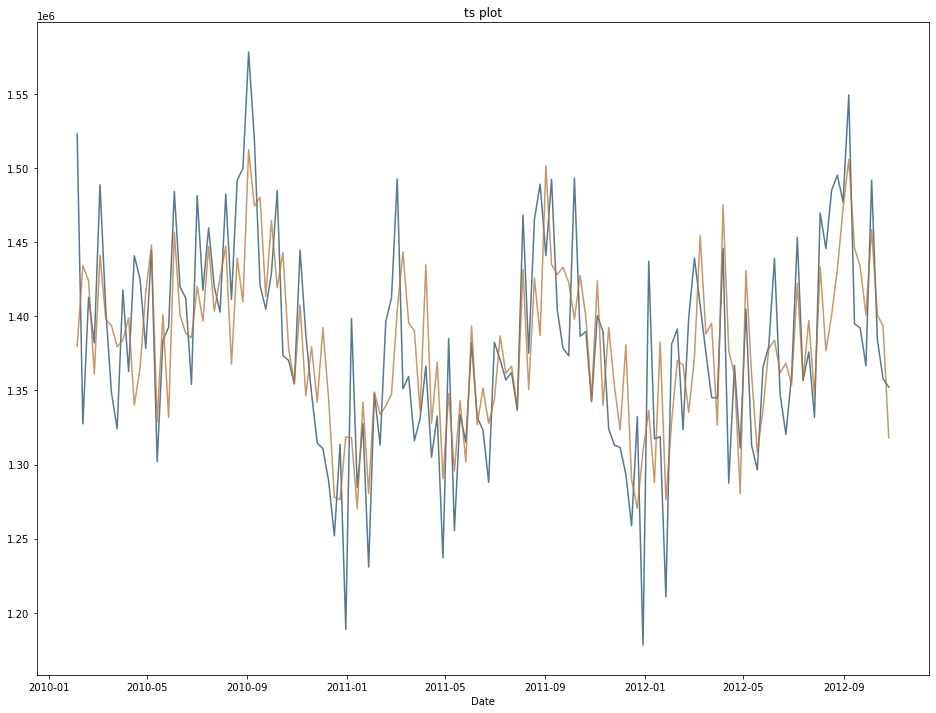

In [ ]:
model_Ar = run_arima(ndf,'ts',14,0,0)

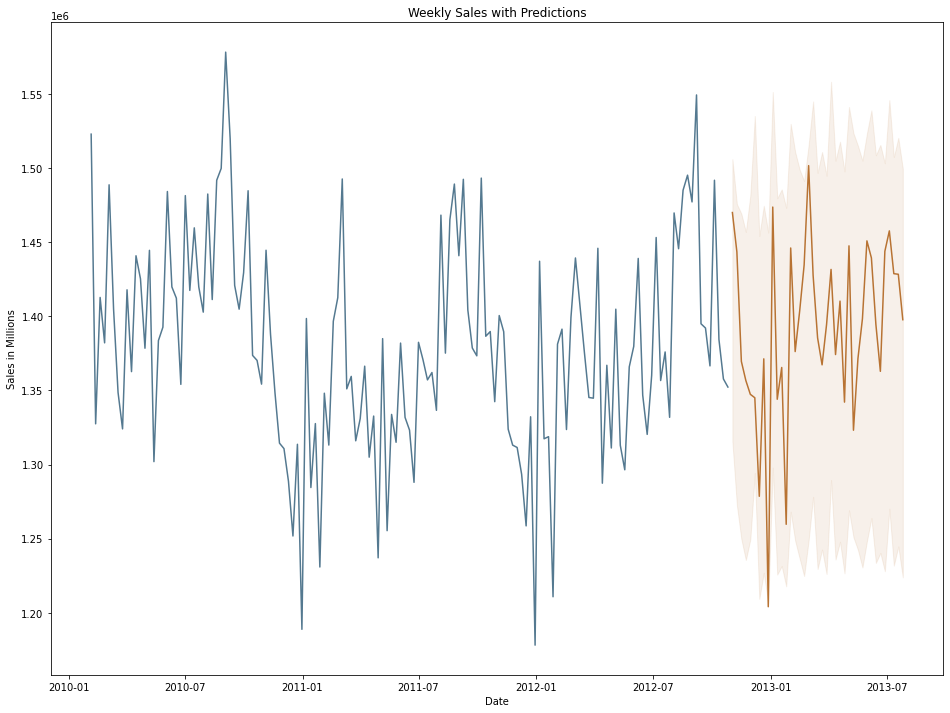

In [ ]:
N  = test.ts.to_numpy().shape[0]
predictions = res_model_Ar.forecast(N)[0]
lower = model_Ar.forecast(N)[2][:,0]
upper = model_Ar.forecast(N)[2][:,1]
x = test.index

x1 =  np.arange(0,143)
train['x'] = x1
x2 =  np.arange(143,182)

poly =np.polyfit(x1,100000*(train['trend'].to_numpy()), deg=3)
y = x1**3*poly[0] + x1**2*poly[1]+x1*poly[2]+poly[3]

y_hat = x2**3*poly[0] + x2**2*poly[1]+x2*poly[2]+poly[3]

test['ts'] = (1+predictions) * (1+train['seasonal'][-52:-13].to_numpy()) *y_hat

plt.figure(figsize=(16,12))
plt.plot(train['ts'],color = '#1B4C6B', alpha =.75)
plt.plot(test['ts'], color='#B87333')
plt.fill_between(x, lower, upper, color='#B87333', alpha=.1)
plt.title("Weekly Sales with Predictions")
plt.xlabel("Date")
plt.ylabel("Sales in Millions")
plt.show()
